In [1]:
#Imports modules:
import os
import operator
import sys
import glob
import argparse

import numpy as np
import numpy.ma as ma
from numpy.ma import masked_array
from numpy.linalg import inv
import math as m
from math import log

import astropy
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
from astropy.visualization import simple_norm
from astropy.visualization import (MinMaxInterval, PercentileInterval, ZScaleInterval, 
                                   SqrtStretch, LogStretch, HistEqStretch,
                                   ImageNormalize)
from astropy.io import fits
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.table import Table
from astropy.cosmology import WMAP7
from astropy.io.votable import parse
from astropy.io.votable import parse_single_table
from astropy.stats import sigma_clipped_stats
from photutils import datasets
from astropy.table import Table
from astropy.wcs import WCS
from astropy.io import ascii
from astropy.coordinates import ICRS, Galactic
from astropy.convolution import Gaussian2DKernel, convolve, convolve_fft
from astropy.stats import sigma_clipped_stats
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.modeling import models, fitting
from astroquery.simbad import Simbad
from astropy.nddata import Cutout2D

from scipy.ndimage import interpolation as interp
from scipy import stats
from scipy import interpolate
from scipy.interpolate import splev, splrep

import matplotlib 
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
import matplotlib as mpl
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import StrMethodFormatter
import matplotlib.dates as mdates
from matplotlib import pylab
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib import cm
import matplotlib.path as mpath
from matplotlib.widgets import SpanSelector
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.widgets as mwidgets
from matplotlib.collections import PatchCollection

import warnings
import datetime
import time

import pandas as pd
from collections import OrderedDict
from astropy.table import Table, Column
import numpy as np
from operator import itemgetter

import sympy
from sympy.interactive import printing
printing.init_printing(use_latex=True)

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

warnings.filterwarnings('ignore')

# USER-DEFINED FUNCTIONS:

In [2]:
def read_Cartesian_Coordinates_File(cart_coords_file):
    '''
    This function reads the "_Cartesian_Coordinates.txt" 
    and returns its contents as three separate numpy arrays: x_mp,y_mp,z_mp
    
    Input Arguments:
    cart_coords_files = Name of the jet along with the file path 
                        written as an array of strings, 
                        where each string is the name of the jet.
                        
    Output Arguments:
    NOTE: "_mp" signifies that these are the most probable solutions 
          for (x,y,z) coordinates
    x_mp = Array of x coordinates from _Cartesian_Coordinatees.txt file
    y_mp = Array of y coordinates from _Cartesian_Coordinatees.txt file
    z_mp = Array of z coordinates from _Cartesian_Coordinatees.txt file
    ''' 
    
    #To initialize the arrays that will save
    #the most probable solutions for Cartesian coordiantes (x,y,z):
    x_mp=[]
    y_mp=[]
    z_mp=[]

    for line in open(cart_coords_file).readlines(): 
        if line.startswith('#'):
            continue
        if line.startswith('\n'):
            continue

        fields = line.split() 
        x_mp.append(fields[0])
        y_mp.append(fields[1]) 
        z_mp.append(fields[2])

    #To convert the appended lists to numpy arrays:
    x_mp=[float(i) for i in x_mp]
    y_mp=[float(i) for i in y_mp]
    z_mp=[float(i) for i in z_mp]
    
   
    #To remove outliers:
    #To remove coordinates that have negative y values:
    #To find the negative values in y_mp vector
    #and store it is a vector:
    neg_values = np.array(y_mp)[np.array(y_mp) < 0]
    for neg_value in neg_values:
        #To find the index corresponding to the negative value:
        i = y_mp.index(neg_value)
        #To remove the negative y values
        #and corresponding x and z values:
        x_mp.remove(x_mp[i])
        y_mp.remove(y_mp[i])
        z_mp.remove(z_mp[i])

    #To correct for the origin:
    x_mp = np.array(x_mp)
    y_mp = np.array(y_mp)
    #print(np.array(x_mp),np.array(y_mp),np.array(z_mp))
   
    return (np.array(x_mp),np.array(y_mp),np.array(z_mp))

In [3]:
def PCA(x, y, z):
    '''
    This function implements Principal Component Analysis 
    on a set of 3-D Cartesian coordiantes with respect to the core of the galaxy. 
    INPUT ARGUMENTS:
    x = An array of x Cartesian coordinates
    y = An array of y Cartesian coordinates
    z = An array of z Cartesian coordinates
    
    OUTPUT ARGUMENTS:
    coords_cal = A matrix of calculated PCA coordinates. 
    PCA_line_coords = A matrix of calculated PCA coordinates 
                      that lie on a straight line.These coordiantes lie 
                      on the line that represents the preferred direction.
    NOTE: 
    PCA_line_coords[:,0] represents the x PCA coordinate that lies on the line
    PCA_line_coords[:,1] represents the y PCA coordinate that lies on the line
    PCA_line_coords[:,2] represents the z PCA coordinate that lies on the line
    t = The scalar paramter to define the point on the preferred line.
    '''
        
    #To create an (3xn) matrix of these coordinates:
    coord_mat = np.array([x, y, z])
    
    #To calculate the mean of each column and save it as an (1x3) row matrix:
    x_col_mean = np.mean(coord_mat[0])
    y_col_mean = np.mean(coord_mat[1])
    z_col_mean = np.mean(coord_mat[2])

    mean_cols = np.array([x_col_mean,y_col_mean,z_col_mean])

    #To normalize the coord_mat matrix and save the result 
    #as an (number of datapoints x number of dimensions) matrix:
    #Dimensions:
    n = 3
    coord_norm = []
    for i in range(0,3,1):
        coord_norm.append(coord_mat[i] - mean_cols[i])
    coord_mat_norm = np.array(coord_norm).T
    coord_mat_norm.shape
    
    #To calculate the Covariance Matrix:
    #To get the size of the matrix:
    #m = [row, col]
    m = coord_mat_norm.shape
    sigma = (1/(m[0]))*(np.matmul(coord_mat_norm.T, coord_mat_norm))

    #To perform Single Value Decomposition (SVD) on the covariance matrix:
    U,S,V = np.linalg.svd(sigma)

    #To find the coefficients of the straight line 
    #that minimizes the projection error:
    coeff = U[:, 0]
    coeff_mat = np.reshape(coeff,(1,3))

    #Validation Check:
    z_cal = np.matmul(coeff.T,coord_mat_norm.T)
    z_cal_mat = np.reshape(z_cal,(len(x),1))

    #To go back to the original:
    U_reduce_z = np.matmul(z_cal_mat, coeff_mat)
    coords_cal = []
    for k in range(len(x)):
        coords_cal.append(U_reduce_z[k,:] + mean_cols)
    coords_cal = np.array(coords_cal)

    #To plot a line through all PCA coordinates:
    #To define an initial PCA coordinate:
    p_i = coords_cal[0,:]

    #To define a scalar "t" parameter:
    #This scalar parameter can have with any integer value. 
    #The negative sign signifies the direction.
    t = -13.00*len(x)

    #To calculate the final (x_f,y_f,z_f) Coordinate 
    #such that it lies on the line:
    p_f  = []
    for i in range(len(p_i)):
        p_f.append(p_i[i] + t*coeff[i])
    p_f = np.array(p_f)
    PCA_line_coords = np.array([p_i, p_f])

    #To Calculate "t" parameters for all projected PCA coordinates:
    t = []
    for i in range(len(coords_cal[:,0])):
        t.append((coords_cal[i,0] - coords_cal[0,0])/coeff[0])

    return coords_cal, PCA_line_coords, t

In [4]:
def binned_statistics(x_data, y_data, nbins):
    '''
    This user-defined function perform binned statistics (mean and standard deviation) 
    on the number of data points within each bin. The bin size is calculated based on 
    the number of bins defined by the user. 
    INPUT ARGUMNETS:
    x_data = A sequence of values to be binned.
    y_data = The data on which the statistic will be computed.
    nbins = Number of bins
    '''
    #Performs binned statistics:
    #Calculates mean:
    bin_means, bin_edges, bin_number = stats.binned_statistic(x_data, y_data, 
                                                              statistic = 'mean', bins = nbins)
    #Calculates standard deviation:
    bin_std, _ , _ = stats.binned_statistic(x_data, y_data, statistic = 'std', bins = nbins)
    
    
    return (bin_means, bin_std, bin_edges, bin_number)

In [5]:
def RemoveEmptyBins(binned_mean, binned_midpoints):
    '''
    This user-defined function removed empty bins and the corresponding bin midpoints.
    '''
    #Finds the empty bins:
    index = np.array(np.where(np.isnan(binned_mean))).flatten()
    
    #Deletes the array elements:
    binned_mean_filtered =  np.delete(binned_mean, index)
    binned_midpoints_filtered = np.delete(binned_midpoints, index)
    
    return binned_mean_filtered, binned_midpoints_filtered

# ROOT DIRECTORY:

In [6]:
#Directory where raw image .fits is stored:
root_working_directory = "/Users/Sailee/Desktop/Relativistic_Jets_Research/WISE/KnotD_Radio/20200303/"
root_working_directory

'/Users/Sailee/Desktop/Relativistic_Jets_Research/WISE/KnotD_Radio/20200303/'

# LOAD FITS IMAGE FILE AND WCS INFORMATION:

In [7]:
#Defines the name of the file:
filename = 'KnotD_Radio'
fits_data = astropy.io.fits.getdata(root_working_directory + filename + ".fits")

In [8]:
#Loads WCS information:
#Loads the FITS hdulist using astropy.io.fits
hdulist = fits.open(root_working_directory + filename + ".fits")

#Parses the WCS keywords in the primary HDU
wcs = WCS(hdulist[0].header, naxis = 2)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 187.704166667  12.3916666667  
CRPIX : -84.2260132  20.6860046  
CD1_1 CD1_2  : -6.5046680636929e-06  2.43199570318491e-06  
CD2_1 CD2_2  : 2.43199570318491e-06  6.50466806369287e-06  
NAXIS : 99  35

In [9]:
#Observation Date/Time:
datetime = Time(hdulist[0].header['DATE-OBS']) 

#Converts to Julian String:
datetime_julian = datetime.jyear_str
datetime_julian

'J2003.415'

In [10]:
#Loads image data:
raw_fits_data = hdulist[0].data

# ACQUIRE WISE DATA:

In [11]:
from astropy.io import ascii
#data = ascii.read("/Users/Sailee/Desktop/Relativistic_Jets_Research/WISE/KnotD_Radio/20200226/WISE_Results/run_20200226/feature_coords/feature_coords.ms.dat")
data = ascii.read("/Users/Sailee/Desktop/Relativistic_Jets_Research/WISE/KnotD_Radio/20200226/WISE_Results/run_20200226/detection_scale_2/detection_scale_2.ms.dat")
data

col1,col2,col3,col4,col5,col6
float64,float64,float64,float64,float64,float64
2003.41615,-2708.90149,964.71846,0.001337,8.263823,50.000001
2003.41615,-2551.81424,942.3731,0.000812,5.015448,50.000001
2003.41615,-3049.71329,1132.13038,0.000616,3.806098,50.000001
2003.41615,-3809.53284,1402.49637,0.000584,3.608452,50.000001
2003.41615,-2394.24277,921.327,0.000583,3.60071,50.000001
2003.41615,-2942.87404,915.60971,0.000517,3.195347,50.000001
2003.41615,-2931.57359,1127.66811,0.000475,2.93539,50.000001
2003.41615,-3222.74341,959.4537,0.000398,2.460307,50.000001
2003.41615,-3304.6436,1006.98845,0.00039,2.409457,50.000001


In [12]:
#Extracts the required data: 
RA_coord_mas = np.array(data['col2'][0:18]) #in mas
DEC_coord_mas = np.array(data['col3'][0:18]) #in mas
pixel_scale = np.array(data['col6'][0:18])
flux_maxima = np.array(data['col4'][0:18])

In [13]:
#Converts the coordinates to degrees:
#Changes to degrees:
component_coords_mas = SkyCoord(RA_coord_mas, DEC_coord_mas, unit = (u.milliarcsecond, u.milliarcsecond), 
                            frame = "icrs", equinox = "J2003.415")
component_coords_degree = SkyCoord(component_coords_mas.ra.deg + hdulist[0].header['CRVAL1'], component_coords_mas.dec.deg + hdulist[0].header['CRVAL2'], 
                        unit = (u.degree, u.degree),
                        frame = "icrs", equinox = "J2003.415")



In [14]:
#Converts to pixel coordinates:
x_coord_pixel, y_coord_pixel = wcs.all_world2pix(component_coords_degree.ra, component_coords_degree.dec, 0.00)
x_coord_pixel, y_coord_pixel

(array([27.41764701, 21.35617179, 42.23446442, 73.82666126, 15.29517735,
        35.29172423, 37.84874742, 46.14745145, 49.81038567, 68.18793223,
        55.43483507, 81.49533029, 48.81316169, 64.76348167, 65.46689921,
        58.50369553, 58.92442155, 67.77867739]),
 array([18.76812348, 20.08015364, 20.37760635, 20.11169155, 21.44748913,
        13.72699695, 21.82678495, 11.54057449, 12.20101286, 23.80358743,
        16.62023581, 20.49280001, 21.1763656 , 22.40465456, 11.54795916,
        24.11161528, 12.14989845, 17.20438893]))

In [15]:
#Zips the coordiantes:
xy_coord_pix_zipped = zip(x_coord_pixel, y_coord_pixel, flux_maxima)

#Sorts the coordinates:
xy_coord_pix_zipped_sorted = sorted(xy_coord_pix_zipped, key = operator.itemgetter(0))

#Unzips the coordinates:
x_coord_pixel_sorted, y_coord_pixel_sorted, flux_maxima_sorted = zip(*xy_coord_pix_zipped_sorted)

#Creates an array:
x_coord_pixel_sorted = np.array(x_coord_pixel_sorted)
y_coord_pixel_sorted = np.array(y_coord_pixel_sorted)
flux_maxima_sorted = np.array(flux_maxima_sorted)

# ACQUIRES THE M87 CORE COORDINATES:

In [16]:
#M87 Core in RA and DEC:
core = SkyCoord(hdulist[0].header['CRVAL1'], hdulist[0].header['CRVAL2'], unit = (u.deg, u.deg))
core.ra.hms

In [17]:
#Defines the pixel coordinates of the M87 core:
core_x_pixel_coord = hdulist[0].header['CRPIX1']
core_y_pixel_coord = hdulist[0].header['CRPIX2']
core_x_pixel_coord, core_y_pixel_coord 

# ACQUIRE JETCURRY DATA:

In [18]:
#Grab Upstream and Downstream Points from the text file
UPSTREAM_BOUNDS = np.array([5, 15])
DOWNSTREAM_BOUNDS = np.array([90, 15])
THETA = 0.26

## ALL COORDINATES:

In [19]:
#Files to read:
#Specify image name/OUTPUT DIRECTORY without extension:
image_file_name = 'KnotD_Radio'
OUTPUT_DIRECTORY = '/Users/Sailee/Desktop/Relativistic_Jets_Research/WISE/KnotD_Radio/20200303/JetCurry_Results/JetCurry_All_Coordinates/'

#Directory of "_flux_maxima_coords.txt" to display maximum flux points::
max_flux_coords_file_name = image_file_name + '_flux_maxima_coords.txt'
max_flux_coords_file = os.path.join(OUTPUT_DIRECTORY, 
                                    max_flux_coords_file_name)

#Directory where _Cartesian_Coordinates.txt is saved:
cart_coords_file_name = image_file_name + '_Cartesian_Coordinates.txt'
cart_coords_file = os.path.join(OUTPUT_DIRECTORY, 
                                cart_coords_file_name)

#Prints Directories:
print("OUTPUT FLUX MAXIMA COORDINATE FILE DIRECTORY:")
print(max_flux_coords_file)
print("\n")
print("OUTPUT CARTESIAN COORDINATE FILE DIRECTORY:")
print(cart_coords_file)

OUTPUT FLUX MAXIMA COORDINATE FILE DIRECTORY:
/Users/Sailee/Desktop/Relativistic_Jets_Research/WISE/KnotD_Radio/20200303/JetCurry_Results/JetCurry_All_Coordinates/KnotD_Radio_flux_maxima_coords.txt


OUTPUT CARTESIAN COORDINATE FILE DIRECTORY:
/Users/Sailee/Desktop/Relativistic_Jets_Research/WISE/KnotD_Radio/20200303/JetCurry_Results/JetCurry_All_Coordinates/KnotD_Radio_Cartesian_Coordinates.txt


In [20]:
#Acquires Max Flux Coordinates:
x_mp_all_coord_no_core, y_mp_all_coord_no_core, z_mp_all_coord_no_core = read_Cartesian_Coordinates_File(cart_coords_file)

In [21]:
#Adds core coordinates:
x_mp_all_coord = np.append(core_x_pixel_coord, x_mp_all_coord_no_core)
y_mp_all_coord = np.append(core_y_pixel_coord, y_mp_all_coord_no_core)
z_mp_all_coord = np.append(0.00, z_mp_all_coord_no_core)

## UPPER BRANCH COORDINATES:

In [22]:
#Files to read:
#Specify image name/OUTPUT DIRECTORY without extension:
image_file_name = 'KnotD_Radio'
OUTPUT_DIRECTORY = '/Users/Sailee/Desktop/Relativistic_Jets_Research/WISE/KnotD_Radio/20200303/JetCurry_Results/JetCurry_Upper_Branch/'

#Directory of "_flux_maxima_coords.txt" to display maximum flux points::
max_flux_coords_file_name = image_file_name + '_flux_maxima_coords.txt'
max_flux_coords_file = os.path.join(OUTPUT_DIRECTORY, 
                                    max_flux_coords_file_name)

#Directory where _Cartesian_Coordinates.txt is saved:
cart_coords_file_name = image_file_name + '_Cartesian_Coordinates.txt'
cart_coords_file = os.path.join(OUTPUT_DIRECTORY, 
                                cart_coords_file_name)

#Prints Directories:
print("OUTPUT FLUX MAXIMA COORDINATE FILE DIRECTORY:")
print(max_flux_coords_file)
print("\n")
print("OUTPUT CARTESIAN COORDINATE FILE DIRECTORY:")
print(cart_coords_file)

OUTPUT FLUX MAXIMA COORDINATE FILE DIRECTORY:
/Users/Sailee/Desktop/Relativistic_Jets_Research/WISE/KnotD_Radio/20200303/JetCurry_Results/JetCurry_Upper_Branch/KnotD_Radio_flux_maxima_coords.txt


OUTPUT CARTESIAN COORDINATE FILE DIRECTORY:
/Users/Sailee/Desktop/Relativistic_Jets_Research/WISE/KnotD_Radio/20200303/JetCurry_Results/JetCurry_Upper_Branch/KnotD_Radio_Cartesian_Coordinates.txt


In [23]:
#Acquires Max Flux Coordinates:
x_mp_upper_coord_no_core, y_mp_upper_coord_no_core, z_mp_upper_coord_no_core = read_Cartesian_Coordinates_File(cart_coords_file)

In [24]:
#Adds core coordinates:
x_mp_upper_coord = np.append(core_x_pixel_coord, x_mp_upper_coord_no_core)
y_mp_upper_coord = np.append(core_y_pixel_coord, y_mp_upper_coord_no_core)
z_mp_upper_coord = np.append(0.00, z_mp_upper_coord_no_core)

## LOWER BRANCH COORDINATES:

In [25]:
#Files to read:
#Specify image name/OUTPUT DIRECTORY without extension:
image_file_name = 'KnotD_Radio'
OUTPUT_DIRECTORY = '/Users/Sailee/Desktop/Relativistic_Jets_Research/WISE/KnotD_Radio/20200303/JetCurry_Results/JetCurry_Lower_Branch/'

#Directory of "_flux_maxima_coords.txt" to display maximum flux points::
max_flux_coords_file_name = image_file_name + '_flux_maxima_coords.txt'
max_flux_coords_file = os.path.join(OUTPUT_DIRECTORY, 
                                    max_flux_coords_file_name)

#Directory where _Cartesian_Coordinates.txt is saved:
cart_coords_file_name = image_file_name + '_Cartesian_Coordinates.txt'
cart_coords_file = os.path.join(OUTPUT_DIRECTORY, 
                                cart_coords_file_name)

#Prints Directories:
print("OUTPUT FLUX MAXIMA COORDINATE FILE DIRECTORY:")
print(max_flux_coords_file)
print("\n")
print("OUTPUT CARTESIAN COORDINATE FILE DIRECTORY:")
print(cart_coords_file)

OUTPUT FLUX MAXIMA COORDINATE FILE DIRECTORY:
/Users/Sailee/Desktop/Relativistic_Jets_Research/WISE/KnotD_Radio/20200303/JetCurry_Results/JetCurry_Lower_Branch/KnotD_Radio_flux_maxima_coords.txt


OUTPUT CARTESIAN COORDINATE FILE DIRECTORY:
/Users/Sailee/Desktop/Relativistic_Jets_Research/WISE/KnotD_Radio/20200303/JetCurry_Results/JetCurry_Lower_Branch/KnotD_Radio_Cartesian_Coordinates.txt


In [26]:
#Acquires Max Flux Coordinates:
x_mp_lower_coord_no_core, y_mp_lower_coord_no_core, z_mp_lower_coord_no_core = read_Cartesian_Coordinates_File(cart_coords_file)

In [27]:
#Adds core coordinates:
x_mp_lower_coord = np.append(core_x_pixel_coord, x_mp_lower_coord_no_core)
y_mp_lower_coord = np.append(core_y_pixel_coord, y_mp_lower_coord_no_core)
z_mp_lower_coord = np.append(0.00, z_mp_lower_coord_no_core)

# UPDATES "ALL COORDINATE" ARRAYS USING UPPER AND LOWER COORIDNATE ARRAYS:

In [28]:
#With respect to upper stream coordinates:
x_append = []
y_append = []
z_append = []

for i in range(len(x_mp_upper_coord)):
    #Acquires the element number:
    index = np.array(np.where(x_mp_upper_coord[i] == x_mp_all_coord)).flatten()
    if len(index) == 0:
        x_append.append(x_mp_upper_coord[i])
        y_append.append(y_mp_upper_coord[i])
        z_append.append(z_mp_upper_coord[i])

In [29]:
#Creates the updated arrays:
x_mp_all = np.append(x_mp_all_coord, x_append)
y_mp_all = np.append(y_mp_all_coord, y_append)
z_mp_all = np.append(z_mp_all_coord, z_append)

In [30]:
#With respect to lower stream coordinates:
x_append = []
y_append = []
z_append = []

for i in range(len(x_mp_lower_coord)):
    #Acquires the element number:
    index = np.array(np.where(x_mp_lower_coord[i] == x_mp_all)).flatten()
    if len(index) == 0:
        x_append.append(x_mp_lower_coord[i])
        y_append.append(y_mp_lower_coord[i])
        z_append.append(z_mp_lower_coord[i])

In [31]:
#Creates the final updated arrays:
x_mp = np.append(x_mp_all, x_append)
y_mp = np.append(y_mp_all, y_append)
z_mp = np.append(z_mp_all, z_append)

# 3D VISUALIZATION:

In [32]:
#Number of bins for running averages:
nbins = 8

#Type of interpolation:
interp_type = "quadratic"

<IPython.core.display.Javascript object>


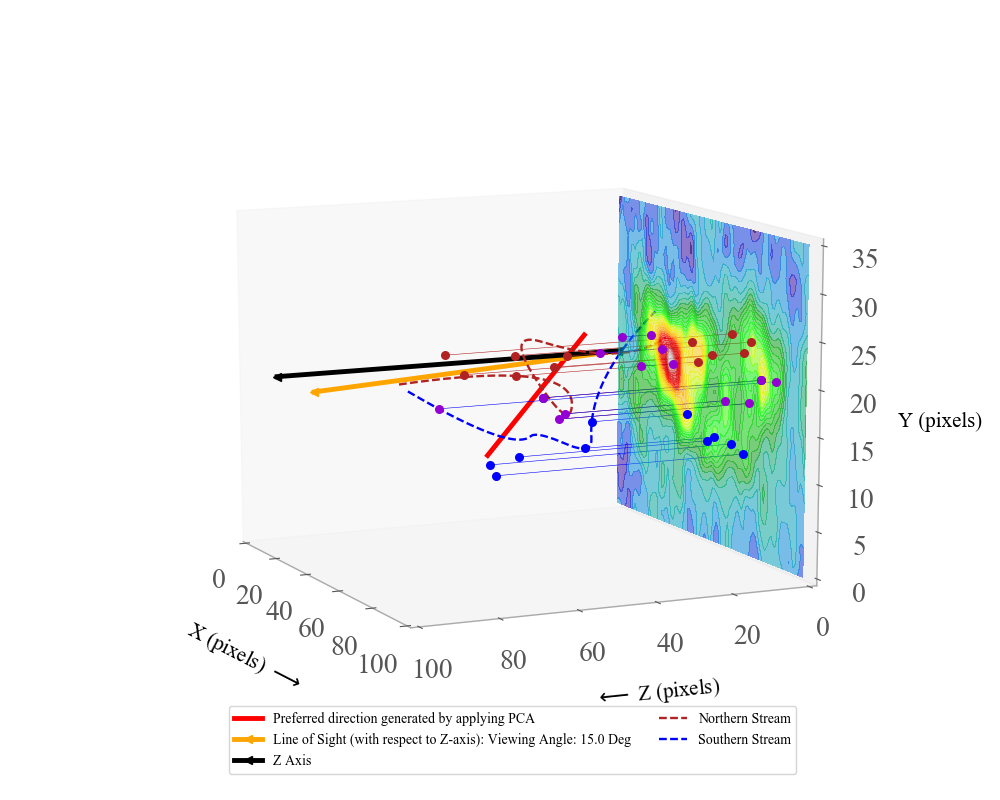

In [33]:
%matplotlib notebook

#To Plot Spline Fit of Flux Maxima:
fig = plt.figure(figsize= (10, 8))

ax = plt.gca(projection = '3d')


# To load the data for Plotting the Spline Fit of Max Flux over the Image:
# By using zdir='y', the y value of these points is fixed to the zs value 0
# and the (x,y) points are plotted on the x and z axes.
# Creates a mesh:
xx, zz = np.meshgrid(np.linspace(0, raw_fits_data.shape[1], raw_fits_data.shape[1]), 
                     np.linspace(0, raw_fits_data.shape[0], raw_fits_data.shape[0]))

#create vertices for a rotated mesh (3D rotation matrix)
X =  xx 
Z =  zz
Y =  10*np.ones(X.shape)

#To plot contours as a Background:
#Normalize the image:
norm = simple_norm(raw_fits_data, 'sqrt', percent = 99.9)

ax.contourf(X, raw_fits_data, Z, 40, norm = norm,
            cmap = cm.spectral,
            alpha = 0.5, zdir = 'y',
            linewidths = 2.0)


#FOR ALL COORDINATES:
#Acquire data from Cartesian Coordinates File
x_unsorted = np.add(np.subtract(x_mp, 15.00), UPSTREAM_BOUNDS[1])
y_unsorted = np.add(np.subtract(y_mp, 13.00), UPSTREAM_BOUNDS[0])
z_unsorted = z_mp

#PCA:
coords_cal, PCA_line_coords, t = PCA(x_unsorted, y_unsorted, z_unsorted);

#PCA Cartesian coordinates:
x_pca_unsorted = coords_cal[:, 0]
y_pca_unsorted = coords_cal[:, 1]
z_pca_unsorted = coords_cal[:, 2]

# #To plot the most probable solutions of from Jet Curry (Red Points) >> 2D Projection:
# ax.scatter(x_unsorted, y_unsorted, zdir='y',
#            color = 'red', 
#            label = "Most Probable Solutions in Cartesian Coordinates", s = 25)


# #The Most Probable Solutions of the non-linear parametrized eqautions:
# ax.scatter3D(x_unsorted, y_unsorted, z_unsorted, zdir = 'y', color = 'red', s = 25)

#To Illustrate the Most Probable Coordinates: (Lines Connecting the Projections):
#Red Dotted Lioned Connecting Most Probable 3D Corrdinates with 2D Projections
# for i,j,k, in zip(x_unsorted, y_unsorted, z_unsorted):
#     ax.plot([i, i],[k,0],
#             [j, j], 
#             color = 'r',
#             marker = ".", linewidth = 0.4)

#To plot the preferred Direction:
'''
#To plot the calculated coordinates (Calculated using PCA):
ax.scatter3D(coords_cal[:,0],coords_cal[:,1],coords_cal[:,2], 
             zdir = 'y', marker = "+", color = 'green',
             s = 30, linewidths = 0.2, 
             label = "Projected Coordinates (using PCA)")
''';

#To plot the lines passing through all PCA coordinates:
ax.plot(PCA_line_coords[:, 0], PCA_line_coords[:,1], PCA_line_coords[:, 2],
        zdir = 'y', color = 'red', linewidth = 3.5, 
        label = "Preferred direction generated by applying PCA")  

#To Plot Origin:
#The Origin coordinates represent the (x,y) Cartesian 
#for coordinates at the start of the stream
#x_origin = UPSTREAM_BOUNDS[0]
#y_origin = UPSTREAM_BOUNDS[1]

x_origin = 0.00
y_origin = raw_fits_data.shape[0]/2.00

#To Plot Line of Sight (LOS):
viewing_angle = 15.00 #LOS in Degrees
length = coords_cal[:, 0][-1] #Length of LOS

#To find the end point:
endx = x_origin + length * np.sin(np.radians(viewing_angle))
endy = y_origin + length * np.cos(np.radians(viewing_angle))

#plot the points
ax.plot([x_origin, endx], [0, length], [y_origin, y_origin], 
        c = "orange", 
        marker = "<", linewidth = 3.5,
        label = "Line of Sight (with respect to Z-axis): Viewing Angle: %s Deg" %(viewing_angle))

#To Plot "z" axis: Here, "z" refers to the one in jet curry paper:
ax.plot([0.00, 0.00],
        [0, length], 
        [y_origin, y_origin], 
        c = "k", marker = "<", linewidth = 3.5, label = "Z Axis") 

##############################################################################################################
##############################################################################################################

#FOR UPPER BRANCH COORDINATES:
#Acquire data from Cartesian Coordinates File
x_unsorted = np.add(np.subtract(x_mp_upper_coord, 15.00), UPSTREAM_BOUNDS[1])
y_unsorted = np.add(np.subtract(y_mp_upper_coord, 13.00), UPSTREAM_BOUNDS[0])
z_unsorted = z_mp_upper_coord

#PCA:
coords_cal, PCA_line_coords, t = PCA(x_unsorted[1:], y_unsorted[1:], z_unsorted[1:]);

#PCA Cartesian coordinates:
x_pca_unsorted = coords_cal[:,0]
y_pca_unsorted = coords_cal[:,1]
z_pca_unsorted = coords_cal[:,2]

#Performs Interpolation:
#Sorts the coordinates with respect to the t parameter:
#Zips the coordinates:
coords_unsorted = zip(x_unsorted[1:], y_unsorted[1:], z_unsorted[1:], t)

#Sorts the coordinates with repsect to t:
coords_sorted = sorted(coords_unsorted, key = itemgetter(3), reverse = True)

#Unzips the coordinates:
x_sorted, y_sorted, z_sorted, t_sorted = zip(*coords_sorted)

#Performs Binned Statistics:
x_sorted_binned_mean, x_sorted_binned_std, x_sorted_bin_edges, x_sorted_bin_number = binned_statistics(t_sorted, x_sorted, 
                                                                                                       nbins)
y_sorted_binned_mean, y_sorted_binned_std, y_sorted_bin_edges, y_sorted_bin_number = binned_statistics(t_sorted, y_sorted, 
                                                                                                       nbins)
z_sorted_binned_mean, z_sorted_binned_std, z_sorted_bin_edges, z_sorted_bin_number = binned_statistics(t_sorted, z_sorted,
                                                                                                       nbins)

#Remove Empty Bins:
x_sorted_binned_mean_filtered, x_sorted_binned_midpoints_filtered = RemoveEmptyBins(x_sorted_binned_mean, (x_sorted_bin_edges[:-1] + x_sorted_bin_edges[1:])/2.00)
y_sorted_binned_mean_filtered, y_sorted_binned_midpoints_filtered = RemoveEmptyBins(y_sorted_binned_mean, (y_sorted_bin_edges[:-1] + y_sorted_bin_edges[1:])/2.00)
z_sorted_binned_mean_filtered, z_sorted_binned_midpoints_filtered = RemoveEmptyBins(z_sorted_binned_mean, (z_sorted_bin_edges[:-1] + z_sorted_bin_edges[1:])/2.00)

#Performs interpolation on the binned coordinates:
#DATA POINTS:
N_i = 1001
t_i = np.linspace(np.min(x_sorted_binned_midpoints_filtered) - 6.00, np.max(x_sorted_binned_midpoints_filtered) + 14.00, N_i)

#Performs interpolation:
x_interp = splrep(x_sorted_binned_midpoints_filtered, x_sorted_binned_mean_filtered,
                                k = 2)
y_interp = splrep(y_sorted_binned_midpoints_filtered, y_sorted_binned_mean_filtered, 
                                k = 2)
z_interp = splrep(z_sorted_binned_midpoints_filtered, z_sorted_binned_mean_filtered, 
                                k = 2)

#Evaluates the interpolated function:
x_new = splev(t_i, x_interp)
y_new = splev(t_i, y_interp)
z_new = splev(t_i, z_interp)

#To plot interpolated values:
ax.plot(x_new, y_new, z_new, 
        zdir='y', color = 'firebrick', linestyle = "dashed", label = "Northern Stream")

# #To plot the most probable solutions of from Jet Curry (Red Points) >> 2D Projection:
# ax.scatter(x_unsorted[1:], y_unsorted[1:], zdir='y',
#            color = 'firebrick', s = 30)

#To Illustrate the Most Probable Coordinates: (Lines Connecting the Projections):
#Red Dotted Lioned Connecting Most Probable 3D Corrdinates with 2D Projections
for i,j,k, in zip(x_unsorted[1:], y_unsorted[1:], z_unsorted[1:]):
    ax.plot([i, i],[k,0],
            [j, j], 
            color = 'firebrick',
            marker = ".", linewidth = 0.4)

## The Most Probable Solutions of the non-linear parametrized eqautions:
# ax.scatter3D(x_unsorted[1:], y_unsorted[1:], z_unsorted[1:], zdir = 'y', color = 'firebrick', s = 30)

##############################################################################################################
##############################################################################################################

#FOR LOWER BRANCH COORDINATES:
#Acquire data from Cartesian Coordinates File
x_unsorted = np.add(np.subtract(x_mp_lower_coord, 15.00), UPSTREAM_BOUNDS[1])
y_unsorted = np.add(np.subtract(y_mp_lower_coord, 13.00), UPSTREAM_BOUNDS[0])
z_unsorted = z_mp_lower_coord

#PCA:
coords_cal, PCA_line_coords, t = PCA(x_unsorted[1:], y_unsorted[1:], z_unsorted[1:]);

#PCA Cartesian coordinates:
x_pca_unsorted = coords_cal[:,0]
y_pca_unsorted = coords_cal[:,1]
z_pca_unsorted = coords_cal[:,2]

#Perfoms Interpolation:
#Sorts the coordinates with respect to the t parameter:
#Zips the coordinates:
coords_unsorted = zip(x_unsorted[1:], y_unsorted[1:], z_unsorted[1:], t)

#Sorts the coordinates with repsect to t:
coords_sorted = sorted(coords_unsorted, key = itemgetter(3), reverse = True)

#Unzips the coordinates:
x_sorted, y_sorted, z_sorted, t_sorted = zip(*coords_sorted)

#Performs Binned Statistics:
x_sorted_binned_mean, x_sorted_binned_std, x_sorted_bin_edges, x_sorted_bin_number = binned_statistics(t_sorted, x_sorted, 
                                                                                                       nbins)
y_sorted_binned_mean, y_sorted_binned_std, y_sorted_bin_edges, y_sorted_bin_number = binned_statistics(t_sorted, y_sorted, 
                                                                                                       nbins)
z_sorted_binned_mean, z_sorted_binned_std, z_sorted_bin_edges, z_sorted_bin_number = binned_statistics(t_sorted, z_sorted,
                                                                                                       nbins)


#Remove Empty Bins:
x_sorted_binned_mean_filtered, x_sorted_binned_midpoints_filtered = RemoveEmptyBins(x_sorted_binned_mean, (x_sorted_bin_edges[:-1] + x_sorted_bin_edges[1:])/2.00)
y_sorted_binned_mean_filtered, y_sorted_binned_midpoints_filtered = RemoveEmptyBins(y_sorted_binned_mean, (y_sorted_bin_edges[:-1] + y_sorted_bin_edges[1:])/2.00)
z_sorted_binned_mean_filtered, z_sorted_binned_midpoints_filtered = RemoveEmptyBins(z_sorted_binned_mean, (z_sorted_bin_edges[:-1] + z_sorted_bin_edges[1:])/2.00)


#Performs interpolation on the binned coordinates:
#DATA POINTS:
N_i = 1001
t_i = np.linspace(np.min(x_sorted_binned_midpoints_filtered) - 6.00, np.max(x_sorted_binned_midpoints_filtered) + 14.00, N_i)

#Performs interpolation:
x_interp = splrep(x_sorted_binned_midpoints_filtered, x_sorted_binned_mean_filtered,
                                k = 2)
y_interp = splrep(y_sorted_binned_midpoints_filtered, y_sorted_binned_mean_filtered, 
                                k = 2)
z_interp = splrep(z_sorted_binned_midpoints_filtered, z_sorted_binned_mean_filtered, 
                                k = 2)

#Evaluates the interpolated function:
x_new = splev(t_i, x_interp)
y_new = splev(t_i, y_interp)
z_new = splev(t_i, z_interp)

#To plot interpolated values:
ax.plot(x_new, y_new, z_new, 
        zdir='y', color = 'blue', linestyle = "dashed", label = "Southern Stream")

# #To plot the most probable solutions of from Jet Curry >> 2D Projection:
# ax.scatter(x_unsorted[1:], y_unsorted[1:], zdir='y',
#            color = 'blue', s = 30)

#To Illustrate the Most Probable Coordinates: (Lines Connecting the Projections):
#Red Dotted Lioned Connecting Most Probable 3D Corrdinates with 2D Projections
for i,j,k, in zip(x_unsorted[1:], y_unsorted[1:], z_unsorted[1:]):
    ax.plot([i, i],[k,0],
            [j, j], 
            color = 'blue',
            marker = ".", linewidth = 0.4)
    
# The Most Probable Solutions of the non-linear parametrized eqautions:
#ax.scatter3D(x_unsorted[1:], y_unsorted[1:], z_unsorted[1:], zdir = 'y', color = 'blue', s = 30)

##############################################################################################################
##############################################################################################################

#Plots upper , lower, and overlapping coordinates:
#3D coordinates and 2D projections:

for i in range(len(x_mp_upper_coord)):
    #Acquires the element number:
    index = np.array(np.where(x_mp_upper_coord[i] == x_mp_lower_coord)).flatten()
    if len(index) != 0:
        if index[0] != 0:
            #The Most Probable Solutions of the non-linear parametrized eqautions:
            ax.scatter3D(x_mp_upper_coord[i] - 15.00 + UPSTREAM_BOUNDS[1], 
                         y_mp_upper_coord[i] - 13.00 + UPSTREAM_BOUNDS[0], 
                         z_mp_upper_coord[i], zdir = 'y', 
                         color = 'darkviolet', s = 30)
            #2D Projections:
            ax.scatter(x_mp_upper_coord[i] - 15.00 + UPSTREAM_BOUNDS[1], 
                       y_mp_upper_coord[i] - 13.00 + UPSTREAM_BOUNDS[0], zdir='y',
               color = 'darkviolet', s = 30)
        else: continue
        
    else: 
        #For Upper Stream Coordinates:
        #The Most Probable Solutions of the non-linear parametrized eqautions:
        ax.scatter3D(x_mp_upper_coord[i] - 15.00 + UPSTREAM_BOUNDS[1], 
                     y_mp_upper_coord[i] - 13.00 + UPSTREAM_BOUNDS[0], 
                     z_mp_upper_coord[i], zdir = 'y', 
                     color = 'firebrick', s = 30)
        #2D Projections:
        ax.scatter(x_mp_upper_coord[i] - 15.00 + UPSTREAM_BOUNDS[1], 
                   y_mp_upper_coord[i] - 13.00 + UPSTREAM_BOUNDS[0], zdir='y',
           color = 'firebrick', s = 30)
        
        #For Lower Stream Coordinates:
        #The Most Probable Solutions of the non-linear parametrized eqautions:
        ax.scatter3D(x_mp_lower_coord[i] - 15.00 + UPSTREAM_BOUNDS[1], 
                     y_mp_lower_coord[i] - 13.00 + UPSTREAM_BOUNDS[0], 
                     z_mp_lower_coord[i], zdir = 'y', 
                     color = 'blue', s = 30)
        #2D Projections:
        ax.scatter(x_mp_lower_coord[i] - 15.00 + UPSTREAM_BOUNDS[1], 
                   y_mp_lower_coord[i] - 13.00 + UPSTREAM_BOUNDS[0], zdir='y',
           color = 'blue', s = 30)
        
#Last coordinate of the lower stream:
#The Most Probable Solutions of the non-linear parametrized eqautions:
ax.scatter3D(x_mp_lower_coord[-1] - 15.00 + UPSTREAM_BOUNDS[1], 
             y_mp_lower_coord[-1] - 13.00 + UPSTREAM_BOUNDS[0], 
             z_mp_lower_coord[i], zdir = 'y', 
             color = 'darkviolet', s = 30)
ax.scatter(x_mp_lower_coord[-1] - 15.00 + UPSTREAM_BOUNDS[1], 
           y_mp_lower_coord[-1] - 13.00 + UPSTREAM_BOUNDS[0], zdir='y',
           color = 'darkviolet', s = 30)

##############################################################################################################
##############################################################################################################

#3-D Plot Visualization Parameters:
ax.grid(False)
ax.zaxis.set_rotate_label(False) 
ax.set_xlabel('X (pixels) $\longrightarrow$', fontsize = 15)
ax.set_ylabel('$\longleftarrow$ Z (pixels)', fontsize = 15)
ax.set_zlabel('Y (pixels)', fontsize = 15, rotation = 0)

ax.xaxis.labelpad = 30
ax.yaxis.labelpad = 30
ax.zaxis.labelpad = 30

ax.tick_params(axis = 'x', pad = 10, labelsize = 20)
ax.tick_params(axis = 'y', pad = 10, labelsize = 20)
ax.tick_params(axis = 'z', pad = 10, labelsize = 20)

#Plots the legend:
ax.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.10), 
          fancybox = True, ncol = 2, borderaxespad = 0.00)

#Sets limits for the plots:
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_zlim(0, 35)

ax.invert_yaxis()

plt.show()